# Modeling Ozone

This data contains the air pollution and meterological data for the Houston, Texas area over 7 years. I will use supervised machine learning to try to predict ozone levels for the next day given the levels for the current day. My target is binary. A non ozone day has low air pollution and an ozone day has high air pollution. 

Data combined from:
https://archive.ics.uci.edu/ml/datasets/ozone+level+detection

This analysis was inspired by this paper: https://ieeexplore.ieee.org/abstract/document/4053100


### questions to get answered

long short-term memory (LSTM) models/networks - artificial recurrent neural network
- unsupervised model
- capable of long term dependencies (crucial for machine learning with time series)
- we're storing some information from each layer while getting rid of some information from the previous layer
theory - https://colah.github.io/posts/2015-08-Understanding-LSTMs/
python application - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

SMOTE for imbalanced data

scaling data for modeling (not needed for bagged trees?)

struggling to use keras for unsupervised learning model

look at classification report as well

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.base import clone
from sklearn.metrics import brier_score_loss
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

seed = 42

In [2]:
# load dataset
data = pd.read_csv('eighthr.data', header=None, index_col=0, parse_dates=True, squeeze=True)
print(data.shape)

(2534, 73)


In [80]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
0,,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,2.3,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.0
1998-01-02,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
1998-01-03,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
1998-01-04,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
1998-01-05,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,?,?,?,?,?,?,?,?,0.58,0.0


In [3]:
# summarize class counts
counts = data.groupby(73).size()
for i in range(len(counts)):
    percent = counts[i] / data.shape[0] * 100
    print('Class=%d, total=%d, percentage=%.3f' % (i, counts[i], percent))

Class=0, total=2374, percentage=93.686
Class=1, total=160, percentage=6.314


There are 2534 days of data and 73 variables. There is significant class imbalance where over 93% of the days are good air quality and about 6% of the days are bad air quality. 

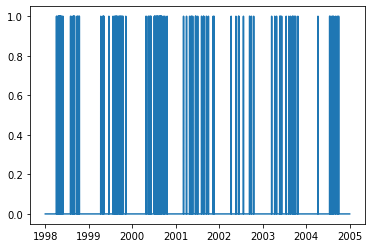

In [4]:
# plot the output variable
pyplot.plot(data.index, data.values[:,-1])
pyplot.show()

From this graph we can see a seasonality in the bad air quality days, mostly in the summer months.

In [9]:
# replace missing observations with 0
values = data.values
values[values=='?'] = 0.0

In [11]:
# frame as supervised learning
# predict ozone tomorrow based on observations today using the sliding window method
supervised = list()
for i in range(len(values) - 1):
    X, y = values[i, :-1], values[i + 1, -1]
    row = np.hstack((X,y))
    supervised.append(row)
supervised = np.array(supervised)

More background for this step can be found here: https://machinelearningmastery.com/time-series-forecasting-supervised-learning/

In [13]:
# split into train-test
# train on 5 years, test on 2 years
split = 365 * 2
train, test = supervised[:-split,:], supervised[-split:,:]
train, test = train.astype('float32'), test.astype('float32')
print(train.shape, test.shape)

(1803, 73) (730, 73)


In [15]:
# save prepared datasets
np.savetxt('train.csv', train, delimiter=',')
np.savetxt('test.csv', test, delimiter=',')

## Naive Prediction Model

In [51]:
# load datasets
train = np.loadtxt('train.csv', delimiter=',')
test = np.loadtxt('test.csv', delimiter=',')
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]
print(naive)

0.07265668330560178


In [52]:
# forecast the test dataset
yhat = [naive for _ in range(len(test))]

Across all items in a set N predictions, the Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes for item i, and (2) the actual outcome. Therefore, the lower the Brier score is for a set of predictions, the better the predictions are calibrated.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

In [53]:
# evaluate forecast
testy = test[:, -1]
bs = brier_score_loss(testy, yhat)
print('Brier Score: %.6f' % bs)

Brier Score: 0.039232


A Brier Skill Score is a metric that tells us how well the Brier Score of a new forecasting model compares to an existing forecasting model. It is calculated as:

Brier Skill Score = (BSE – BSN) / BSE

where:

BSE = Brier Score of existing model

BSN = Brier Score of new model

If a Brier Skill Score is positive, then the new model makes more accurate predictions. If the Brier Skill Score is negative, then the new model makes worse predictions. And if the Brier Skill Score is equal to zero, then the new model offers no improvement over the existing model.

For a model to be skilful, it must have a score better than the score of the naive forecast.

We expect that the calculated BSS for the naive forecast would be 0.0. Going forward, we are interested in maximizing this score, e.g. larger BSS scores are better.

https://www.statology.org/brier-score/

In [54]:
# calculate brier skill score
bs_ref = bs
bss = (bs_ref - bs) / (bs_ref)
print('Brier Skill Score: %.6f' % bss)

Brier Skill Score: 0.000000


The naive probability of an ozone day event is about 7.2%. Now we can explore some machine learning methods to see if we can improve this forecast.

## Ensemble Tree Models

In [40]:
# load datasets
train = np.loadtxt('train.csv', delimiter=',')
test = np.loadtxt('test.csv', delimiter=',')
# split into inputs/outputs
trainX, trainy, testX, testy = train[:,:-1],train[:,-1],test[:,:-1],test[:,-1]

In [41]:
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]
# forecast the test dataset
yhat = [naive for _ in range(len(test))]
# calculate naive bs
bs_ref = brier_score_loss(testy, yhat)

In [42]:
# evaluate a sklearn model
def evaluate_once(bs_ref, template, trainX, trainy, testX, testy):
    # fit model
    model = clone(template)
    model.fit(trainX, trainy)
    # predict probabilities for 0 and 1
    probs = model.predict_proba(testX)
    # keep the probabilities for class=1 only
    yhat = probs[:, 1]
    # calculate brier score
    bs = brier_score_loss(testy, yhat)
    # calculate brier skill score
    bss = (bs - bs_ref) / (0 - bs_ref)
    return bss

In [43]:
# evaluate an sklearn model n times
def evaluate(bs_ref, model, trainX, trainy, testX, testy, n=10):
    scores = [evaluate_once(bs_ref, model, trainX, trainy, testX, testy) for _ in range(n)]
    print('>%s, bss=%.6f' % (type(model), np.mean(scores)))
    return scores

In [44]:
# evaluate a suite of ensemble tree methods
scores, names = list(), list()
n_trees=100

In [45]:
# bagging
model = BaggingClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('bagging')

><class 'sklearn.ensemble._bagging.BaggingClassifier'>, bss=0.069997


In [46]:
# extra
model = ExtraTreesClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('extra')

><class 'sklearn.ensemble._forest.ExtraTreesClassifier'>, bss=0.109502


In [47]:
# gbm
model = GradientBoostingClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('gbm')

><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=0.123434


In [48]:
# rf
model = RandomForestClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('rf')

><class 'sklearn.ensemble._forest.RandomForestClassifier'>, bss=0.106870


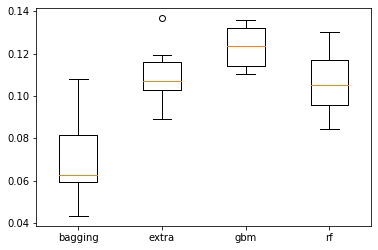

In [49]:
# plot results
pyplot.boxplot(scores, labels=names)
pyplot.show()

## run xgboost model

I will now dive deeper into Gradient Boosting models through parameter tuning.

From the mean BSS scores, it suggests that extra trees, stochastic gradient boosting, and random forest models are the most skillful. All of the models on all of their runs showed skill over the naive forecast (positive scores). The distribution of the BSS scores for Extra Trees, Gradient Boosting, and Random Forest all look encouraging.

><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=0.120630
><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=0.144771
><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=0.093518
><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=0.192498


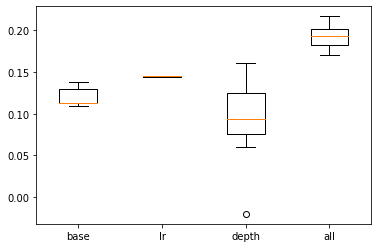

In [55]:
# evaluate a suite of ensemble tree methods
scores, names = list(), list()
# base
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=3)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('base')
# learning rate
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, subsample=1.0, max_depth=3)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('lr')
# depth
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=0.7, max_depth=7)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('depth')
# all
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, subsample=0.7, max_depth=7)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('all')
# plot results
pyplot.boxplot(scores, labels=names)
pyplot.show()

The results suggest that the change to the learning rate and number of trees alone introduced some lift over the default configuration. The results also show that the ‘all’ configuration that included each change resulted in the best mean BSS.

Reference: https://machinelearningmastery.com/how-to-develop-a-probabilistic-forecasting-model-to-predict-air-pollution-days/

## SMOTE

How would different would these models be if I evened out the class imbalance?

In [94]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


In [87]:
sm = SMOTE(random_state=seed)
X_train_res, y_train_res = sm.fit_sample(trainX, trainy.ravel())

In [89]:
print("Before OverSampling, counts of label '1': {}".format(sum(trainy == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(trainy == 0))) 
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 131
Before OverSampling, counts of label '0': 1672 

After OverSampling, the shape of train_X: (3344, 72)
After OverSampling, the shape of train_y: (3344,) 

After OverSampling, counts of label '1': 1672
After OverSampling, counts of label '0': 1672


In [92]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=seed) 
tree_clf.fit(X_train_res, y_train_res.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [95]:
tree_cv_score = cross_val_score(tree_clf, X_train_res, y_train_res.ravel(), cv=3)
mean_tree_cv_score = np.mean(tree_cv_score)

print(f"Mean Cross Validation Score: {mean_tree_cv_score :.2%}")

Mean Cross Validation Score: 79.24%


><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=-1.654138
><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=-2.360672
><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=-1.055441
><class 'sklearn.ensemble._gb.GradientBoostingClassifier'>, bss=-1.219495


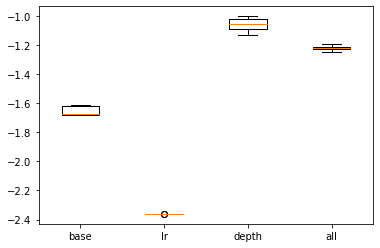

In [96]:
# evaluate a suite of ensemble tree methods
scores, names = list(), list()
# base
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=3)
avg_bss = evaluate(bs_ref, model, X_train_res, y_train_res.ravel(), testX, testy)
scores.append(avg_bss)
names.append('base')
# learning rate
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, subsample=1.0, max_depth=3)
avg_bss = evaluate(bs_ref, model, X_train_res, y_train_res.ravel(), testX, testy)
scores.append(avg_bss)
names.append('lr')
# depth
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=0.7, max_depth=7)
avg_bss = evaluate(bs_ref, model, X_train_res, y_train_res.ravel(), testX, testy)
scores.append(avg_bss)
names.append('depth')
# all
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, subsample=0.7, max_depth=7)
avg_bss = evaluate(bs_ref, model, X_train_res, y_train_res.ravel(), testX, testy)
scores.append(avg_bss)
names.append('all')
# plot results
pyplot.boxplot(scores, labels=names)
pyplot.show()

Why did SMOTE make my models worse?

Try using resampling instead of SMOTE


### Expand on this section

plot feature importance
PCA? 
show train and test accuracies

In [65]:
def plot_feature_importances(model, title='Feature Importance for Model'):
    n_features = trainX.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title(title)

## Unsupervised Learning

In [81]:
#import tensorflow as tf

In [82]:
#from tensorflow import keras

In [97]:
from keras.layers import LSTM

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Alex\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\Alex\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\Alex\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\Alex\anaconda3\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\Alex\anaconda3\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.

During handling of the above exception, another

TypeError: can only concatenate str (not "list") to str